# 🔍 Unit 3: Anomaly Detection

**Course:** Advanced Machine Learning (AICC 303)  
**Topics:**
*   3.1 Anomaly Detection Methods (Statistical vs ML vs DL)
*   3.2 Isolation Forest
*   3.3 Autoencoders for Anomaly Detection
*   3.4 One-class Classification

**Definition:** Anomaly detection (or outlier detection) is the identification of rare items, events, or observations which raise suspicions by differing significantly from the majority of the data.

---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import torch
import torch.nn as nn
import torch.optim as optim

# Setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data Generation
We will generate a synthetic dataset with two clusters ('Normal' behavior) and add some random points ('Anomalies').

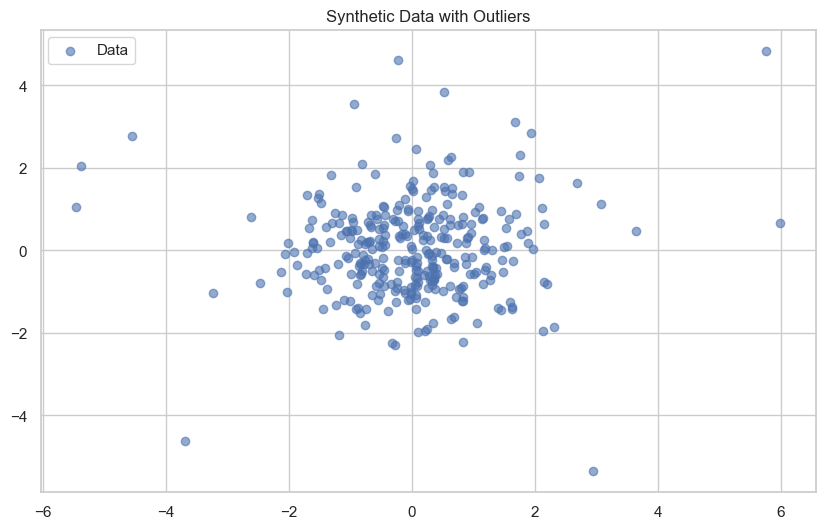

In [5]:
# Generate Normal Data
X, _ = make_blobs(n_samples=300, centers=1, cluster_std=1.0, center_box=(0, 0))

# Generate Anomalies (Uniform noise far from center)
X_outliers = np.random.uniform(low=-6, high=6, size=(20, 2))

# Combine
X = np.vstack([X, X_outliers])

# Plot
plt.scatter(X[:, 0], X[:, 1], color='b', alpha=0.6, label='Data')
plt.title("Synthetic Data with Outliers")
plt.legend()
plt.show()

## 2. Statistical Methods (Z-Score)
Assume data follows a Gaussian distribution. Points far from the mean (e.g., $>3\sigma$) are outliers.

**Limit:** Works well only for simple, Gaussian-like data.

## 3. Isolation Forest (Syllabus 3.2)

**Concept:** It explicitly isolates anomalies rather than profiling normal points.
*   It builds random trees.
*   Anomalies are "few and different", so they are isolated closer to the root of the tree (shorter path length).
*   Normal points require more splits to be isolated (longer path length).

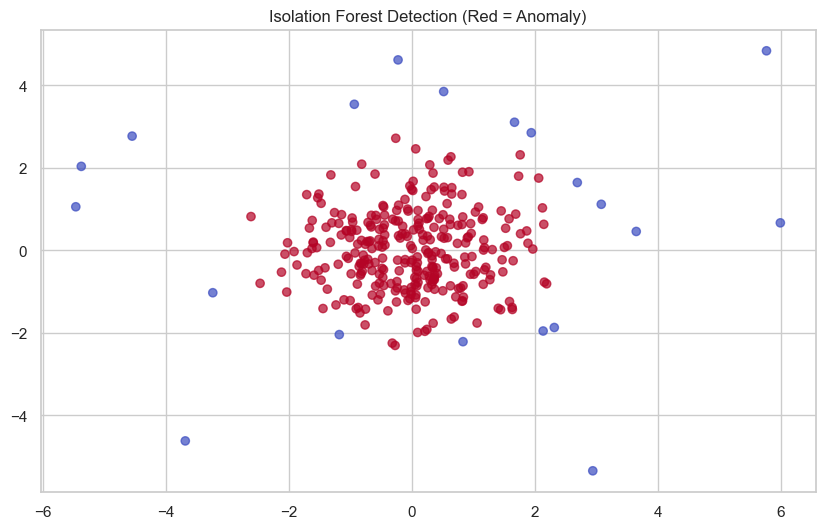

In [6]:
iso_forest = IsolationForest(contamination=0.06, random_state=42)
y_pred_iso = iso_forest.fit_predict(X)
# -1 for outliers, 1 for inliers

plt.scatter(X[:, 0], X[:, 1], c=y_pred_iso, cmap='coolwarm', alpha=0.7)
plt.title("Isolation Forest Detection (Red = Anomaly)")
plt.show()

## 4. One-Class SVM (Syllabus 3.4)

**Concept:** A variation of SVM that learns a decision boundary surrounding the normal data points. Anything outside this boundary is an outlier.
It is a **Semi-Supervised** method (needs only 'normal' data to train).

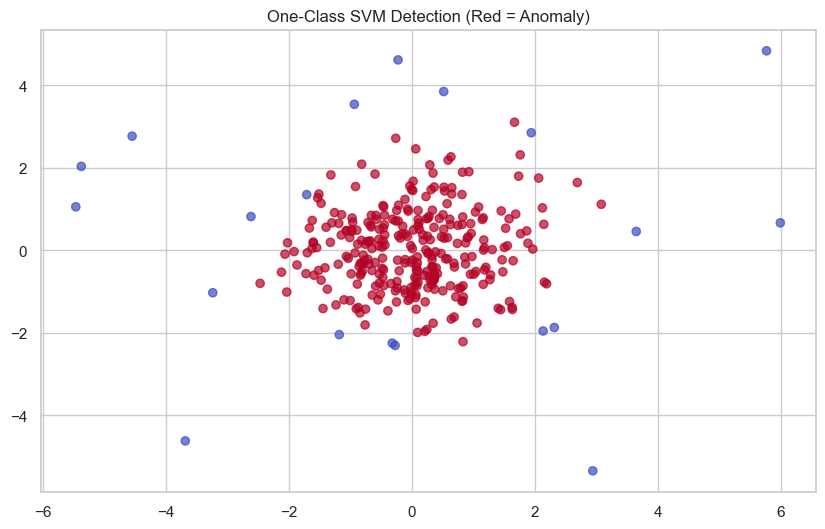

In [7]:
oc_svm = OneClassSVM(nu=0.06, kernel="rbf", gamma=0.1)
y_pred_svm = oc_svm.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred_svm, cmap='coolwarm', alpha=0.7)
plt.title("One-Class SVM Detection (Red = Anomaly)")
plt.show()

## 5. Autoencoders for Anomaly Detection (Syllabus 3.3)

**Concept (Deep Learning):** 
An Autoencoder is a neural network trained to copy its input to its output ($X \to \hat{X}$) through a bottleneck (compressed latent space).

**Hypothesis:** The network learns the pattern of *Normal* data. It cannot reconstruct *Anomalies* well.
**Anomaly Score:** Reconstruction Error ($MSE = |X - \hat{X}|^2$).

Reconstruction Error Threshold: 3.0678


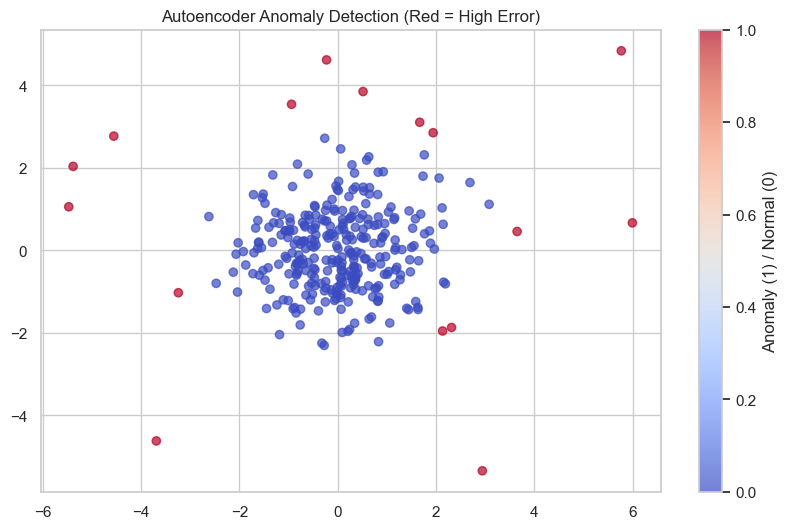

In [8]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Autoencoder in PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train Autoencoder
autoencoder = Autoencoder(input_dim=X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Convert to PyTorch tensor
X_tensor = torch.FloatTensor(X_scaled).to(device)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    outputs = autoencoder(X_tensor)
    loss = criterion(outputs, X_tensor)
    loss.backward()
    optimizer.step()

# Calculate Reconstruction Error
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(X_tensor).cpu().numpy()

mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Determine Threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
y_pred_ae = [1 if error > threshold else 0 for error in mse]

print(f"Reconstruction Error Threshold: {threshold:.4f}")

# Plot
plt.scatter(X[:, 0], X[:, 1], c=y_pred_ae, cmap='coolwarm', alpha=0.7)
plt.title("Autoencoder Anomaly Detection (Red = High Error)")
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.show()

### Conclusion
*   **Isolation Forest:** Best general-purpose algorithm for tabular data.
*   **One-Class SVM:** Good for complex boundaries if tuned well.
*   **Autoencoders:** The standard for complex, high-dimensional data (e.g., Images, Time Series anomalies).